# Cluster compositions

Check cluster proporites to explore cell-types in clusters

In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

#### load immune cohort:

In [57]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_4k_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [61]:
immune_cohort = cohort[cohort.cells_information.getattr('is_immune')]

#### Filter myeloid cohort

In [54]:
myeloid_cohort = get_requested_subset(immune_cohort, 'MYELOIDS')

Will be performed on myeloids
IMMUNE CLUSTERING in path 	 /storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv 	 is used for defining which cells are myeloids
Cluster 5 is defined to be myeloids


In [55]:
MYELOID_COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/myeloid_cells_normalized_5.5.22_protein_coding_genes.pkl'

pickle.dump((myeloid_cohort), open(MYELOID_COHORT_PATH, 'wb'), protocol=4)

#### Filter CD8 cohort

In [62]:
CD8_cohort = get_requested_subset(immune_cohort, 'CYTOTOXIC_T_CELLS')

Will be performed on cytotoxic T cells


In [63]:
CD8_COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/CD8_cells_normalized_5.5.22_protein_coding_genes.pkl'

pickle.dump((CD8_cohort), open(CD8_COHORT_PATH, 'wb'), protocol=4)

#### Load myeloid cohort:

In [3]:
MYELOID_COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/myeloid_cells_normalized_5.5.22_protein_coding_genes.pkl'
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/myeloid/myeloid_bhtsne_5.5.22.csv'
CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'

myeloid_cohort = pickle.load(open(MYELOID_COHORT_PATH, 'rb'))
subcohort = myeloid_cohort

#### Load CD8 cohort:

In [65]:
CD8_COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/CD8_cells_normalized_5.5.22_protein_coding_genes.pkl'
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/CD8/CD8_bhtsne_5.5.22.csv'
CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'

CD8_cohort = pickle.load(open(CD8_COHORT_PATH, 'rb'))
subcohort = CD8_cohort

#### Load tSNE

In [66]:
subcohort.import_tSNE(TSNE_PATH)
subcohort.zscore_normalization()

### Present M1/M2 genes on tSNE

In [67]:
MHC2_GENES = ['HLA-DMA', 'HLA-DMB', 'HLA-DO',
             'HLA-DOA', 'HLA-DOB', 'HLA-DP', 'HLA-DPA1',
             'HLA-DPB1', 'HLA-DQ', 'HLA-DQA1', 'HLA-DQA2',
             'HLA-DQB1', 'HLA-DQB2', 'HLA-DR', 'HLA-DRA',
             'HLA-DRB1', 'HLA-DRB3', 'HLA-DRB4', 'HLA-DRB5']
M2_genes = ['IL10', 'TGFB1']
M1_genes = ['TNF', 'CXCL9', 'CXCL10']
MHC2_genes = [g for g in MHC2_GENES if g in subcohort.gene_names]

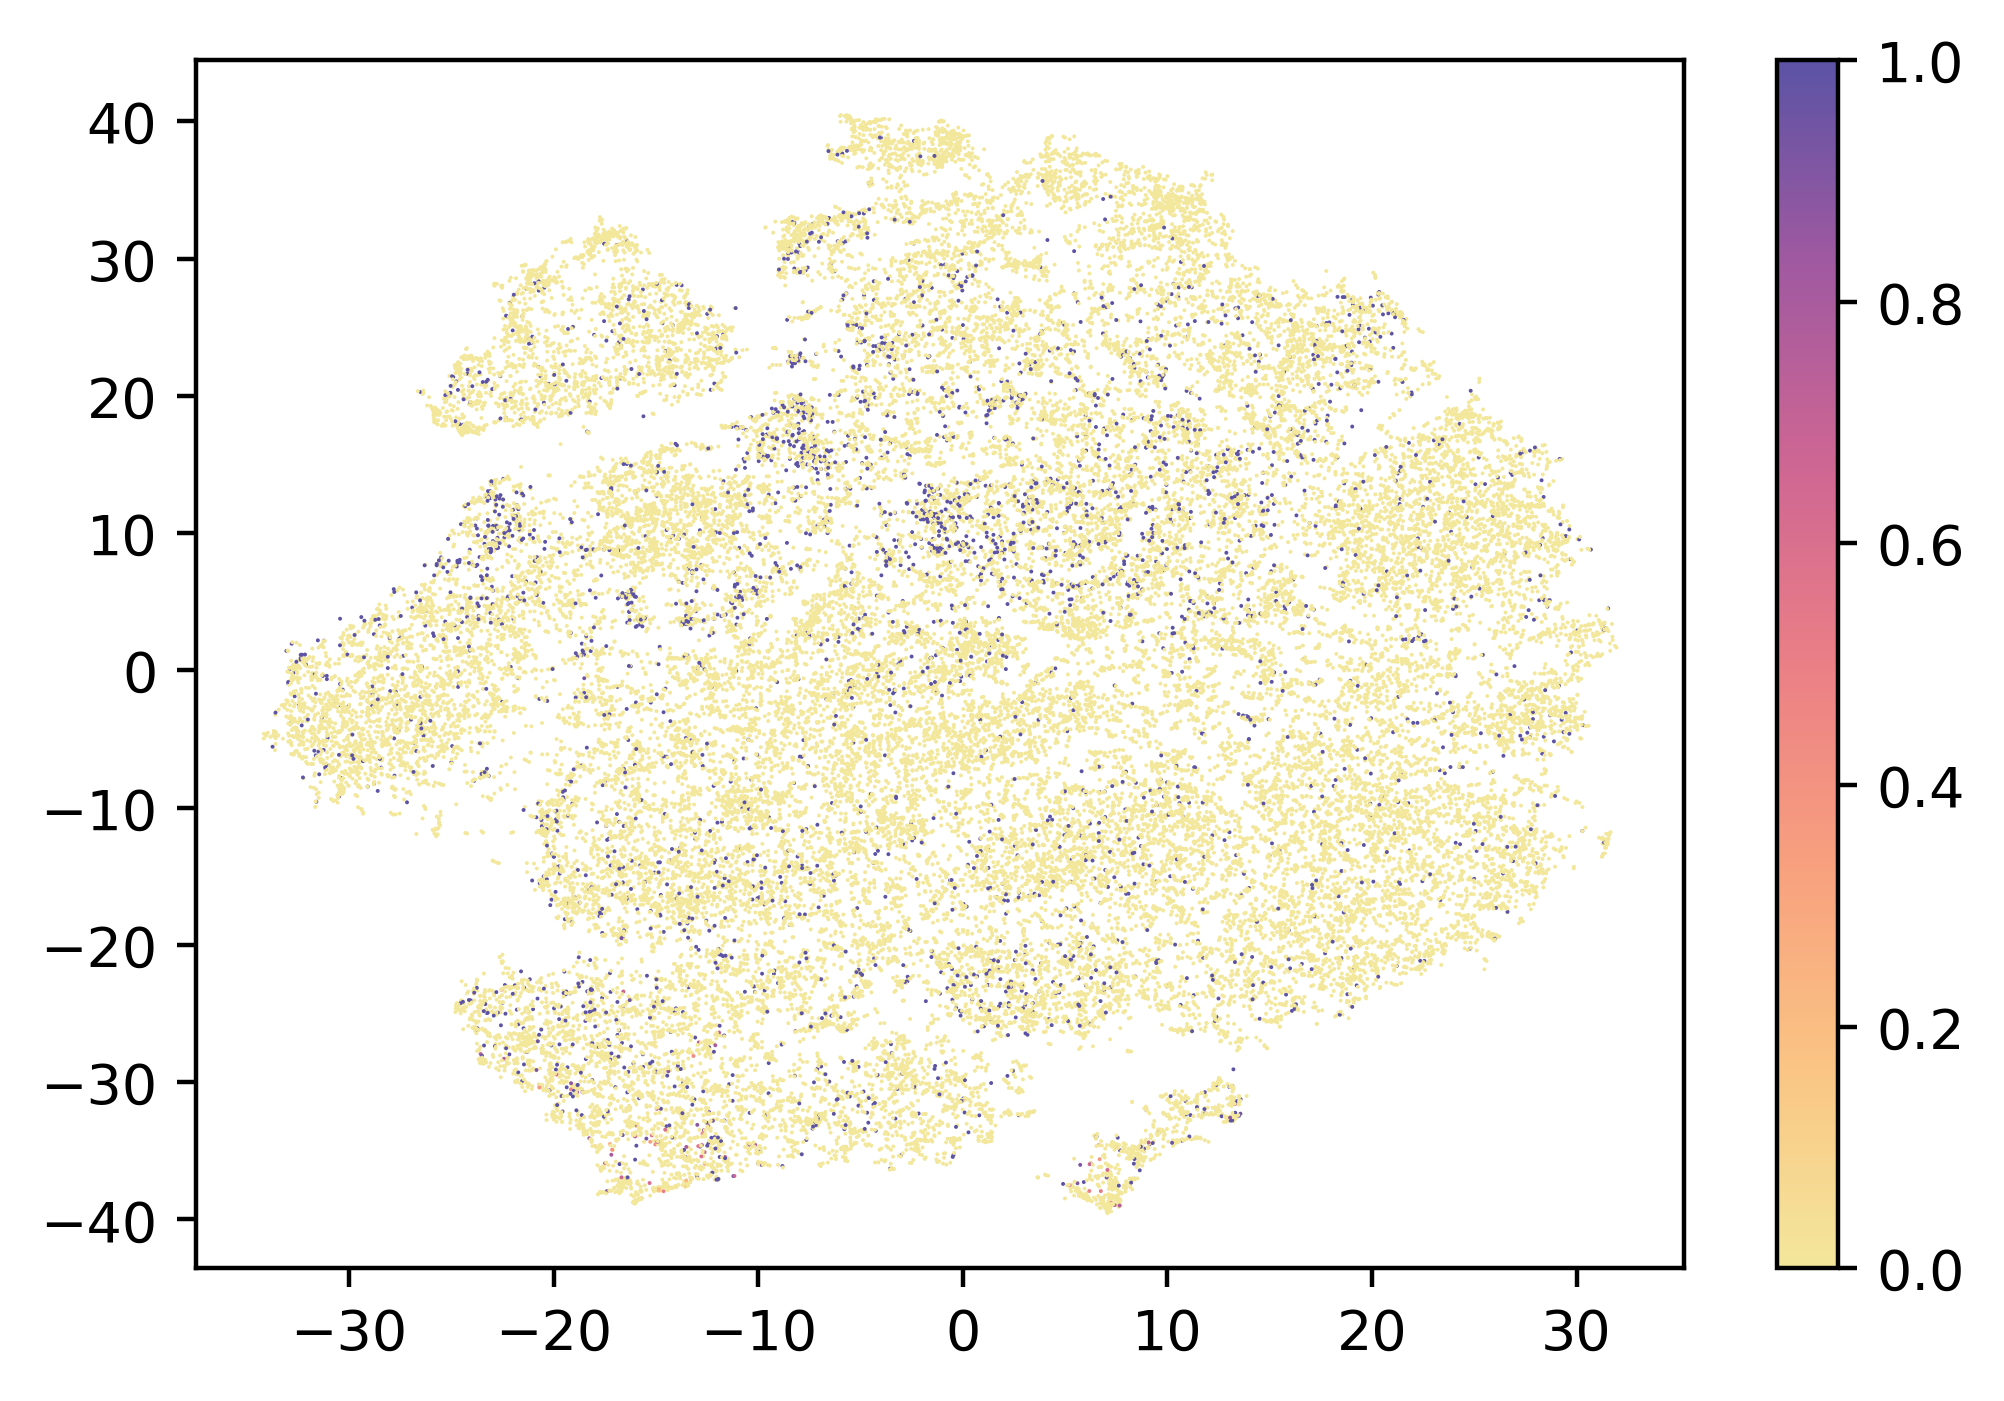

In [68]:
subcohort.plot_tsne_gene(M1_genes[0])

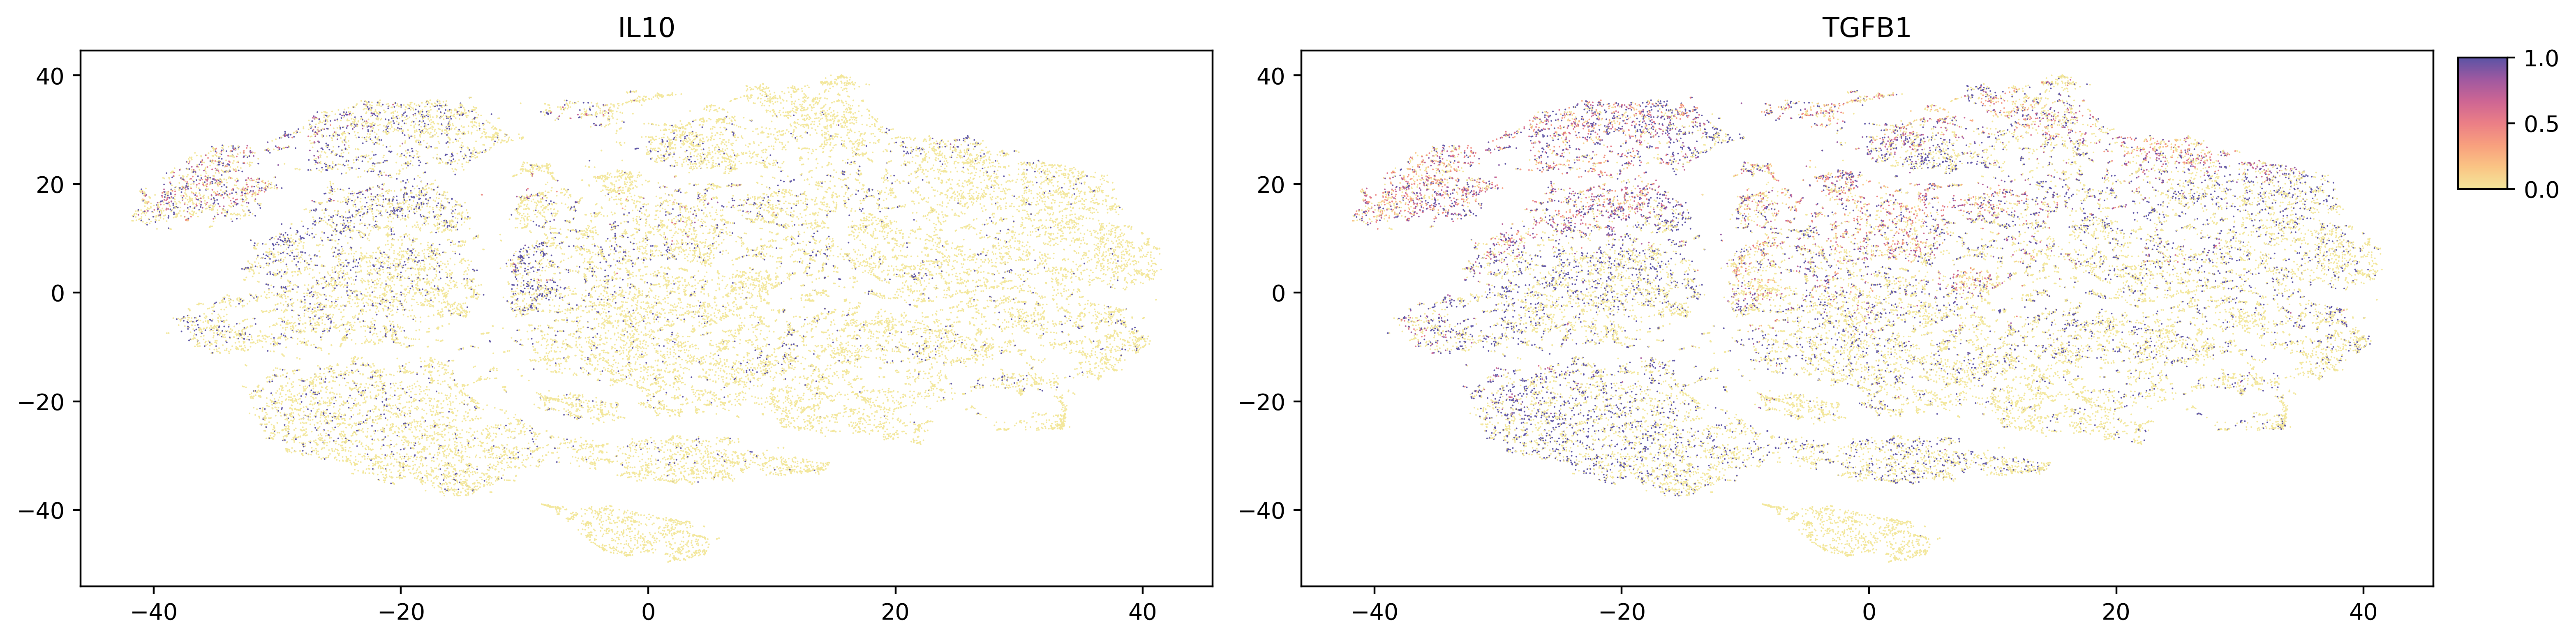

In [7]:
subcohort.plot_tsne_genes(M2_genes)

#### Load cluster mapping df:

In [69]:
mapping_barcodes = pd.read_csv(CLUSTERING_PATH)
mapping_barcodes = mapping_barcodes.drop(columns=[col for col in mapping_barcodes.columns if not col in ['Sample', 'Barcode', 'Cluster']])


#### Explore M1 and M2 genes:

In [70]:
# [f for f in myeloid_cohort.features if 'ENSG00000136634' in f]
[ g for g in subcohort.gene_names if 'IFNG' in g]

['IFNGR1', 'IFNG', 'IFNGR2']

In [71]:
gene_threshold = 1
df = pd.DataFrame(columns=['Cluster', 'Group', 'Gene', '% cells'])

for CLUSTER_IDX in range(1,11): 
    cluster_filtered_df = mapping_barcodes[mapping_barcodes.Cluster == CLUSTER_IDX]
    cluster_cohort = subcohort.get_subset_by_identifiers(cluster_filtered_df.Sample, cluster_filtered_df.Barcode)
    cluster_cohort.import_tSNE(TSNE_PATH)
    cluster_cohort.zscore_normalization()
    
    for gene_name in M2_genes:
#         p_myeloids = sum(myeloid_cohort.counts[:, myeloid_cohort.gene_names.index(gene_name)] > gene_threshold) / myeloid_cohort.number_of_cells
        p_cluster = sum(cluster_cohort.counts[:, cluster_cohort.gene_names.index(gene_name)] > gene_threshold) / cluster_cohort.number_of_cells
        df = df.append(pd.DataFrame([[CLUSTER_IDX, 'M2', gene_name, p_cluster]], columns=df.columns))

    for gene_name in M1_genes:
        p_cluster = sum(cluster_cohort.counts[:, cluster_cohort.gene_names.index(gene_name)] > gene_threshold) / cluster_cohort.number_of_cells
        df = df.append(pd.DataFrame([[CLUSTER_IDX, 'M1', gene_name, p_cluster]], columns=df.columns))

    MHC_p_myeloids =[]
    MHC_p_cluster =[]
    for mhc_gene_name in MHC2_genes:    
        MHC_p_cluster.append(sum(cluster_cohort.counts[:, cluster_cohort.gene_names.index(mhc_gene_name)] > gene_threshold) / cluster_cohort.number_of_cells)
    df = df.append(pd.DataFrame([[CLUSTER_IDX, 'M1', 'MHC2', np.average(MHC_p_cluster)
    ]], columns=df.columns))
    

ZeroDivisionError: division by zero

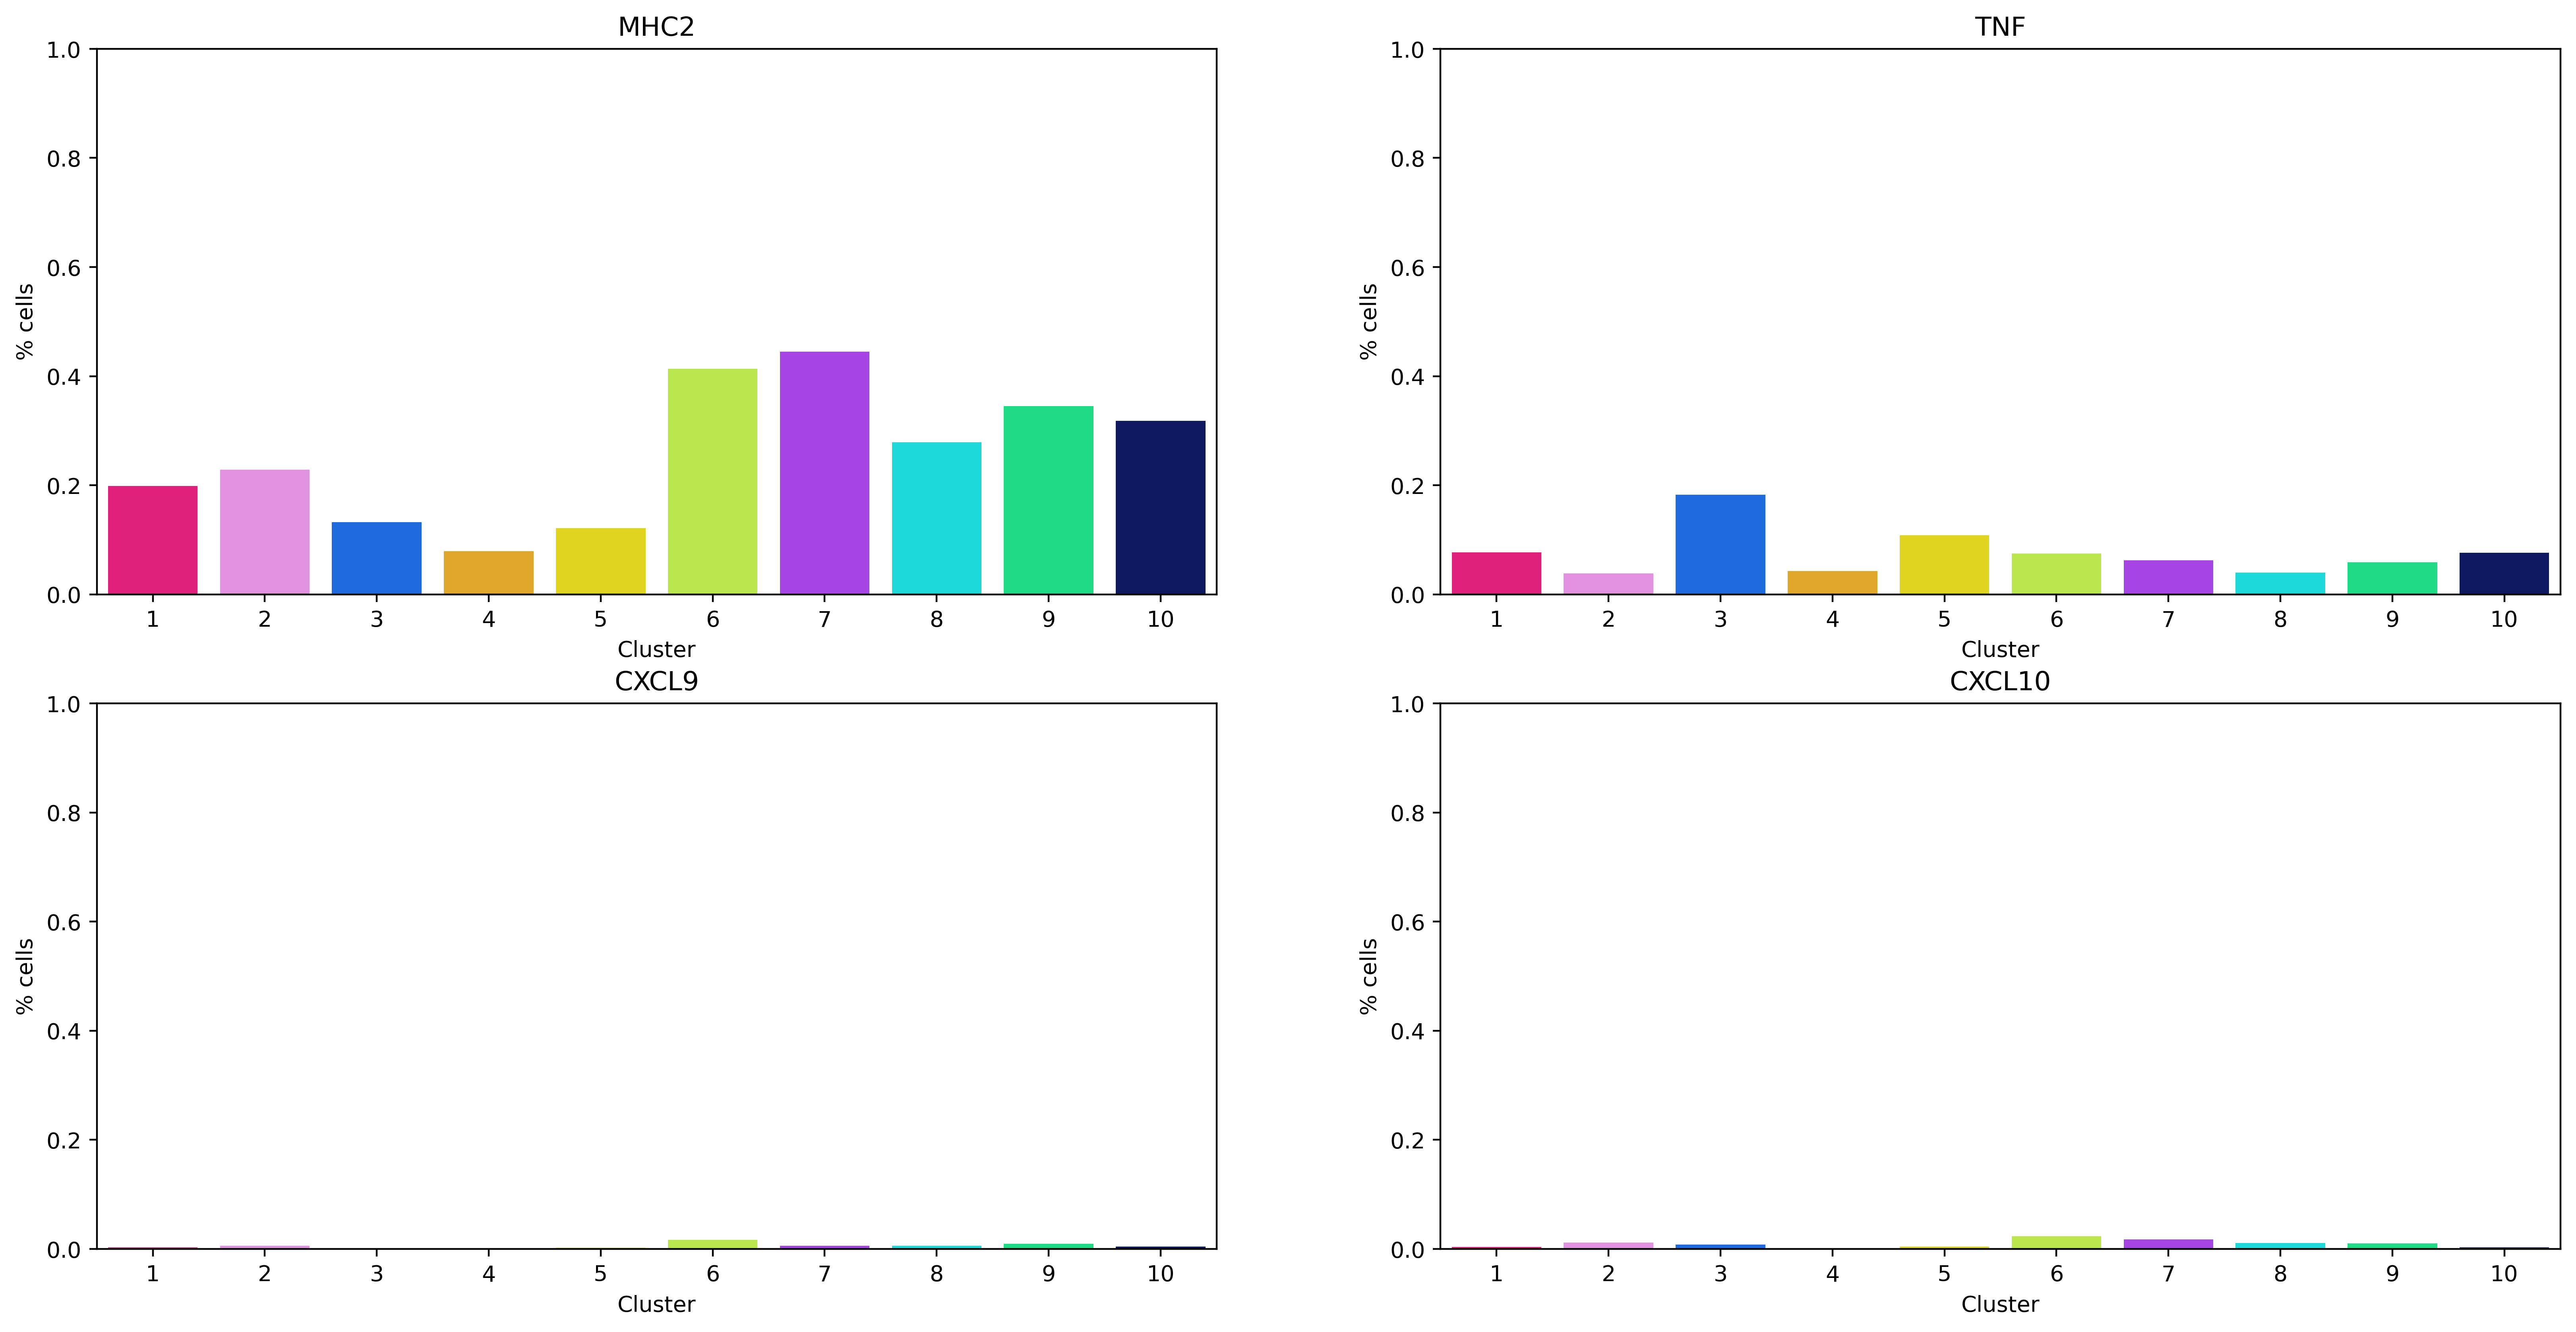

In [73]:
n_genes = len(M1_genes)+1

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]
palette_clustering = {cluster_idx:colors[cluster_idx-1] for cluster_idx in sorted(set(df.Cluster))}
(fig,axes) = plt.subplots(2, int(np.ceil(n_genes/2)), figsize=(20, 10))
axes = axes.ravel()

for ax_idx, gene_name in enumerate(['MHC2']+M1_genes):
    sns.barplot(x='Cluster', y='% cells', data=df[df.Gene==gene_name], ax=axes[ax_idx], palette=palette_clustering, dodge=False).set(ylim=(0, 1), title=gene_name);

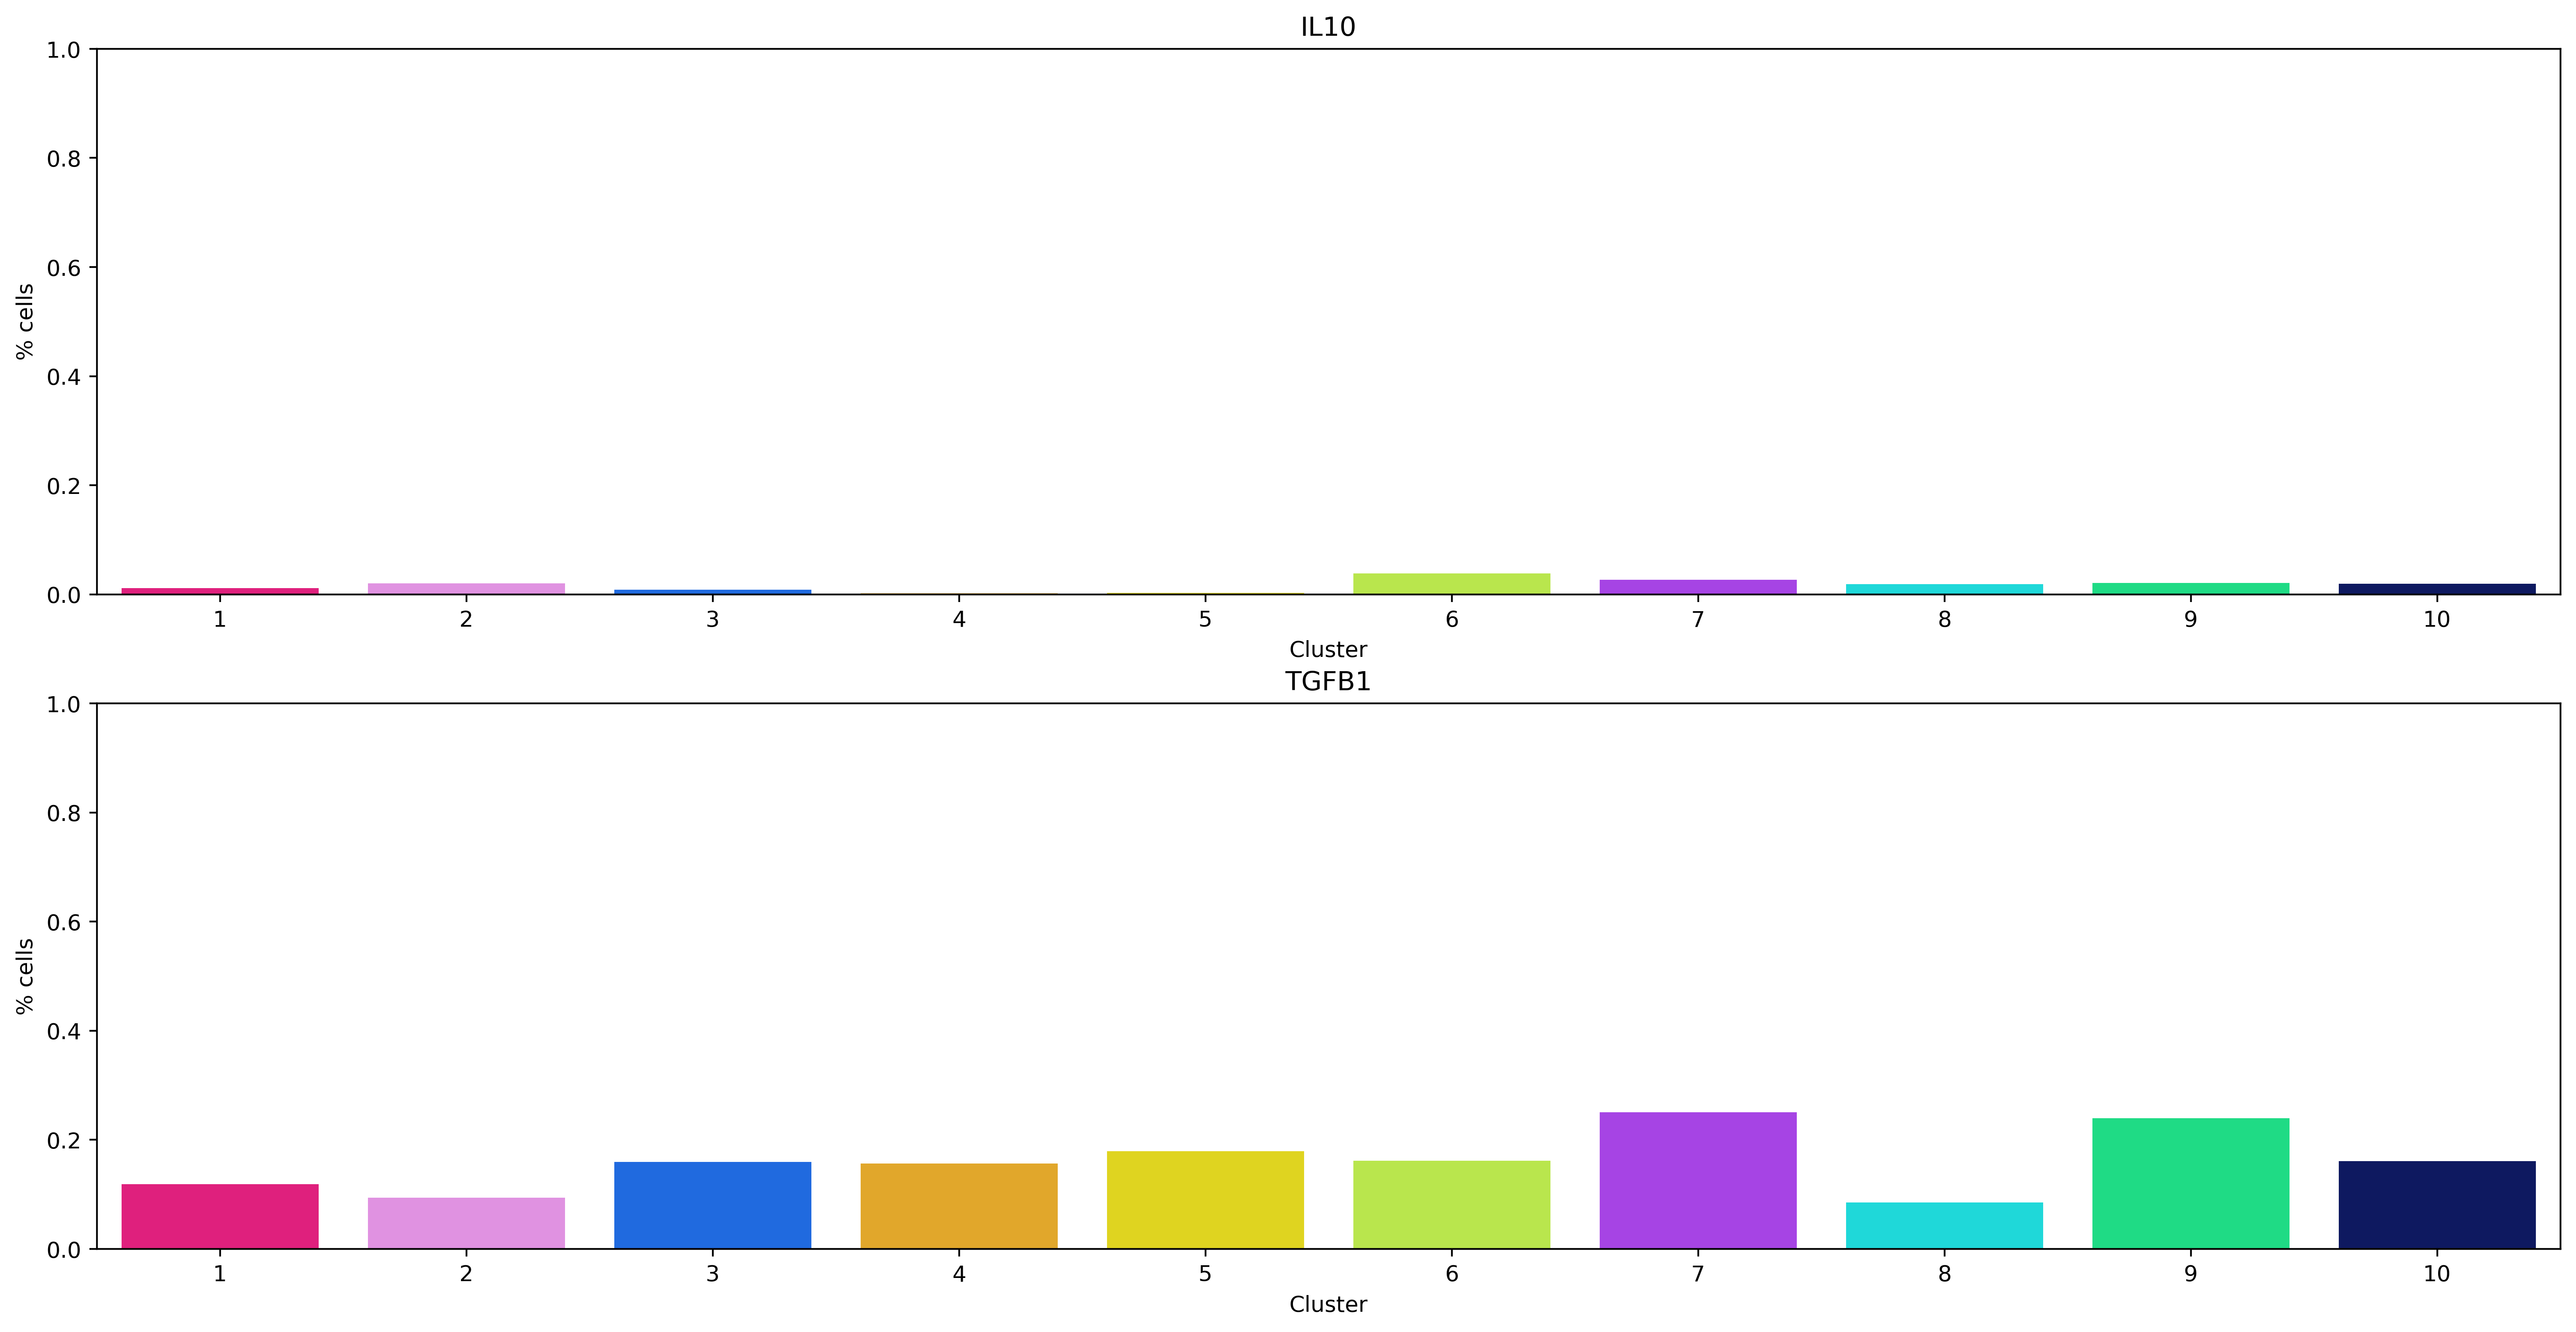

In [74]:
n_genes = len(M2_genes)

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired           [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,100)])[[84, 99, 15 , 70, 60, 53,  92, 23,  30,  1, 40, 80, 40, 12, 13, 14]]
palette_clustering = {cluster_idx:colors[cluster_idx-1] for cluster_idx in sorted(set(df.Cluster))}
(fig,axes) = plt.subplots(2, int(np.ceil(n_genes/2)), figsize=(20, 10))
axes = axes.ravel()

for ax_idx, gene_name in enumerate(M2_genes):
    sns.barplot(x='Cluster', y='% cells', data=df[df.Gene==gene_name], ax=axes[ax_idx], palette=palette_clustering, dodge=False).set(ylim=(0, 1), title=gene_name);

#### Explore a specific cluster

In [ ]:
CLUSTER_IDX = 4


cluster_filtered_df = myeloid_mapping_barcodes[myeloid_mapping_barcodes.Cluster == CLUSTER_IDX]
cluster_cohort = myeloid_cohort.get_subset_by_identifiers(cluster_filtered_df.Sample, cluster_filtered_df.Barcode)
MYELOID_TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/myeloid/myeloid_bhtsne_5.5.22.csv'
cluster_cohort.import_tSNE(MYELOID_TSNE_PATH)
cluster_cohort.zscore_normalization()

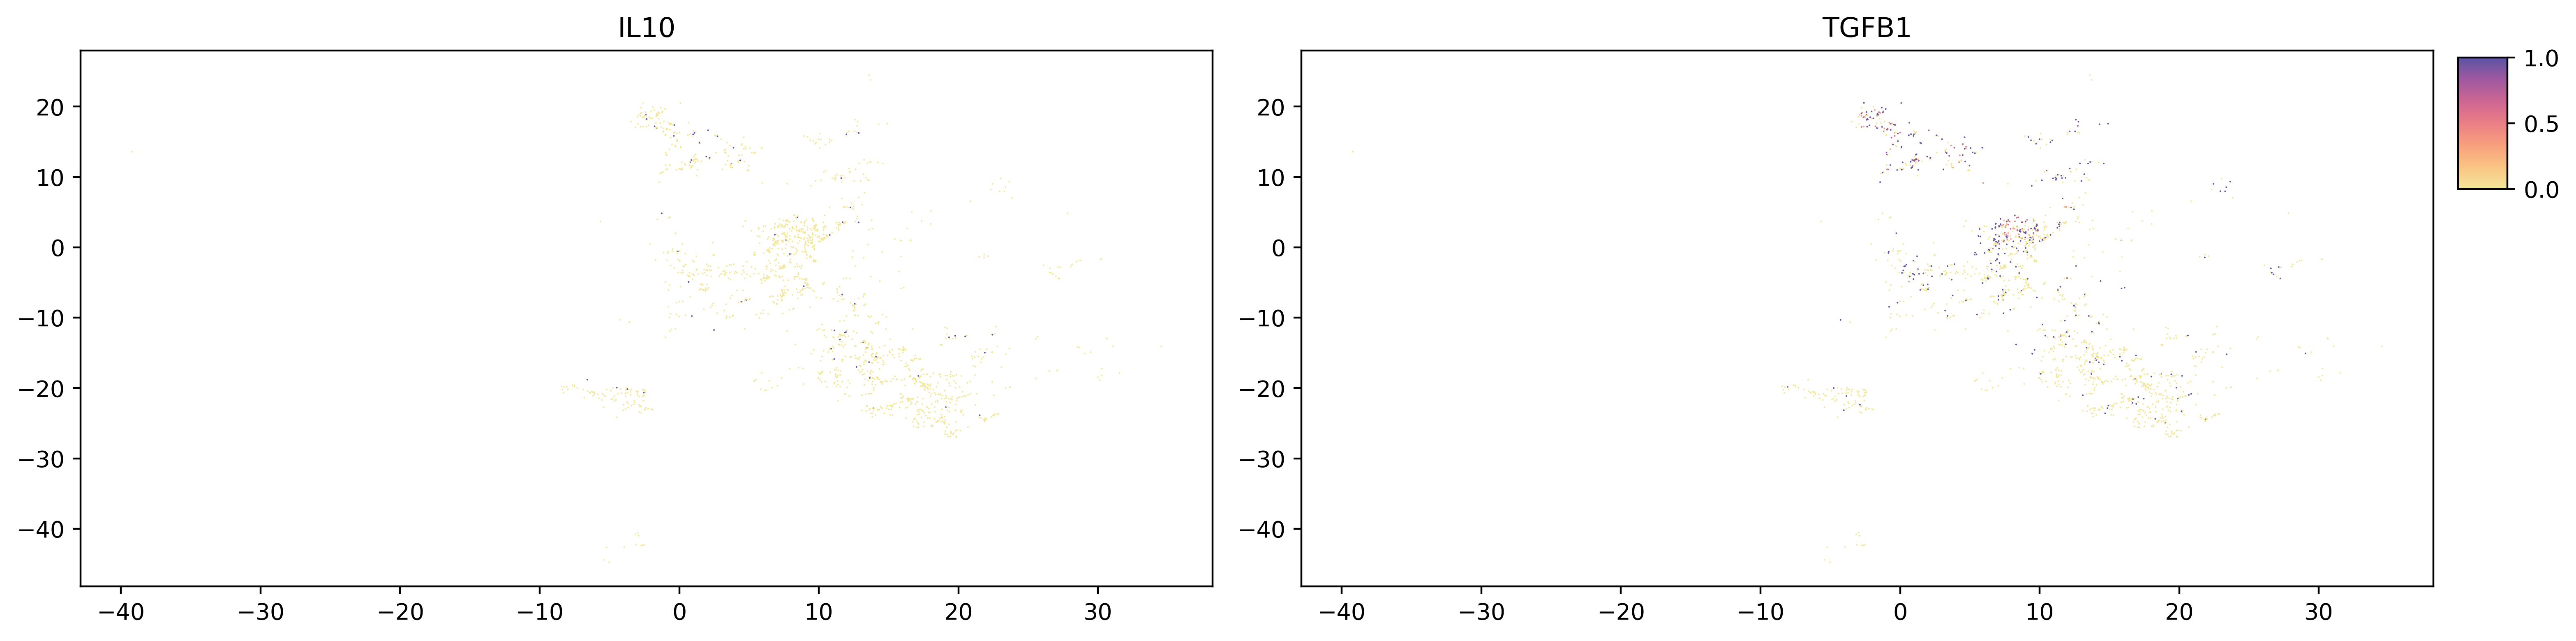

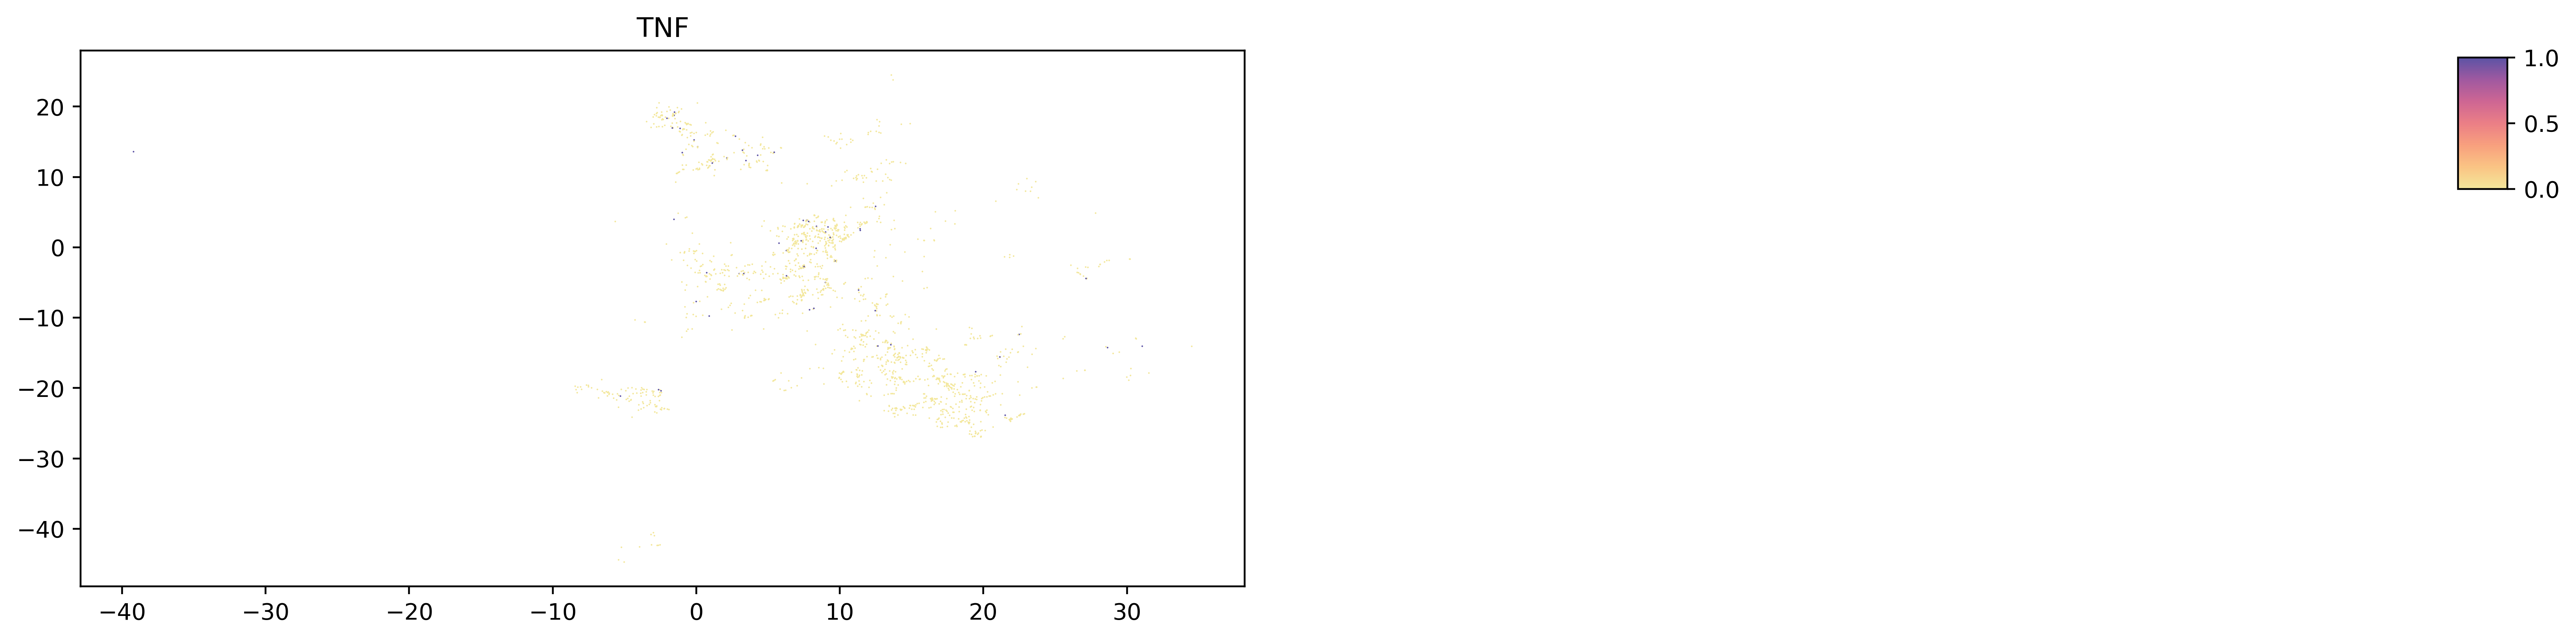

In [98]:
cluster_cohort.plot_tsne_genes(M2_genes)
cluster_cohort.plot_tsne_genes(M1_genes)

# DEBUG

In [ ]:
size = len(myeloid_mapping_barcodes[myeloid_mapping_barcodes.Cluster==2]) + len(myeloid_mapping_barcodes[myeloid_mapping_barcodes.Cluster==7])
size/len(myeloid_mapping_barcodes)

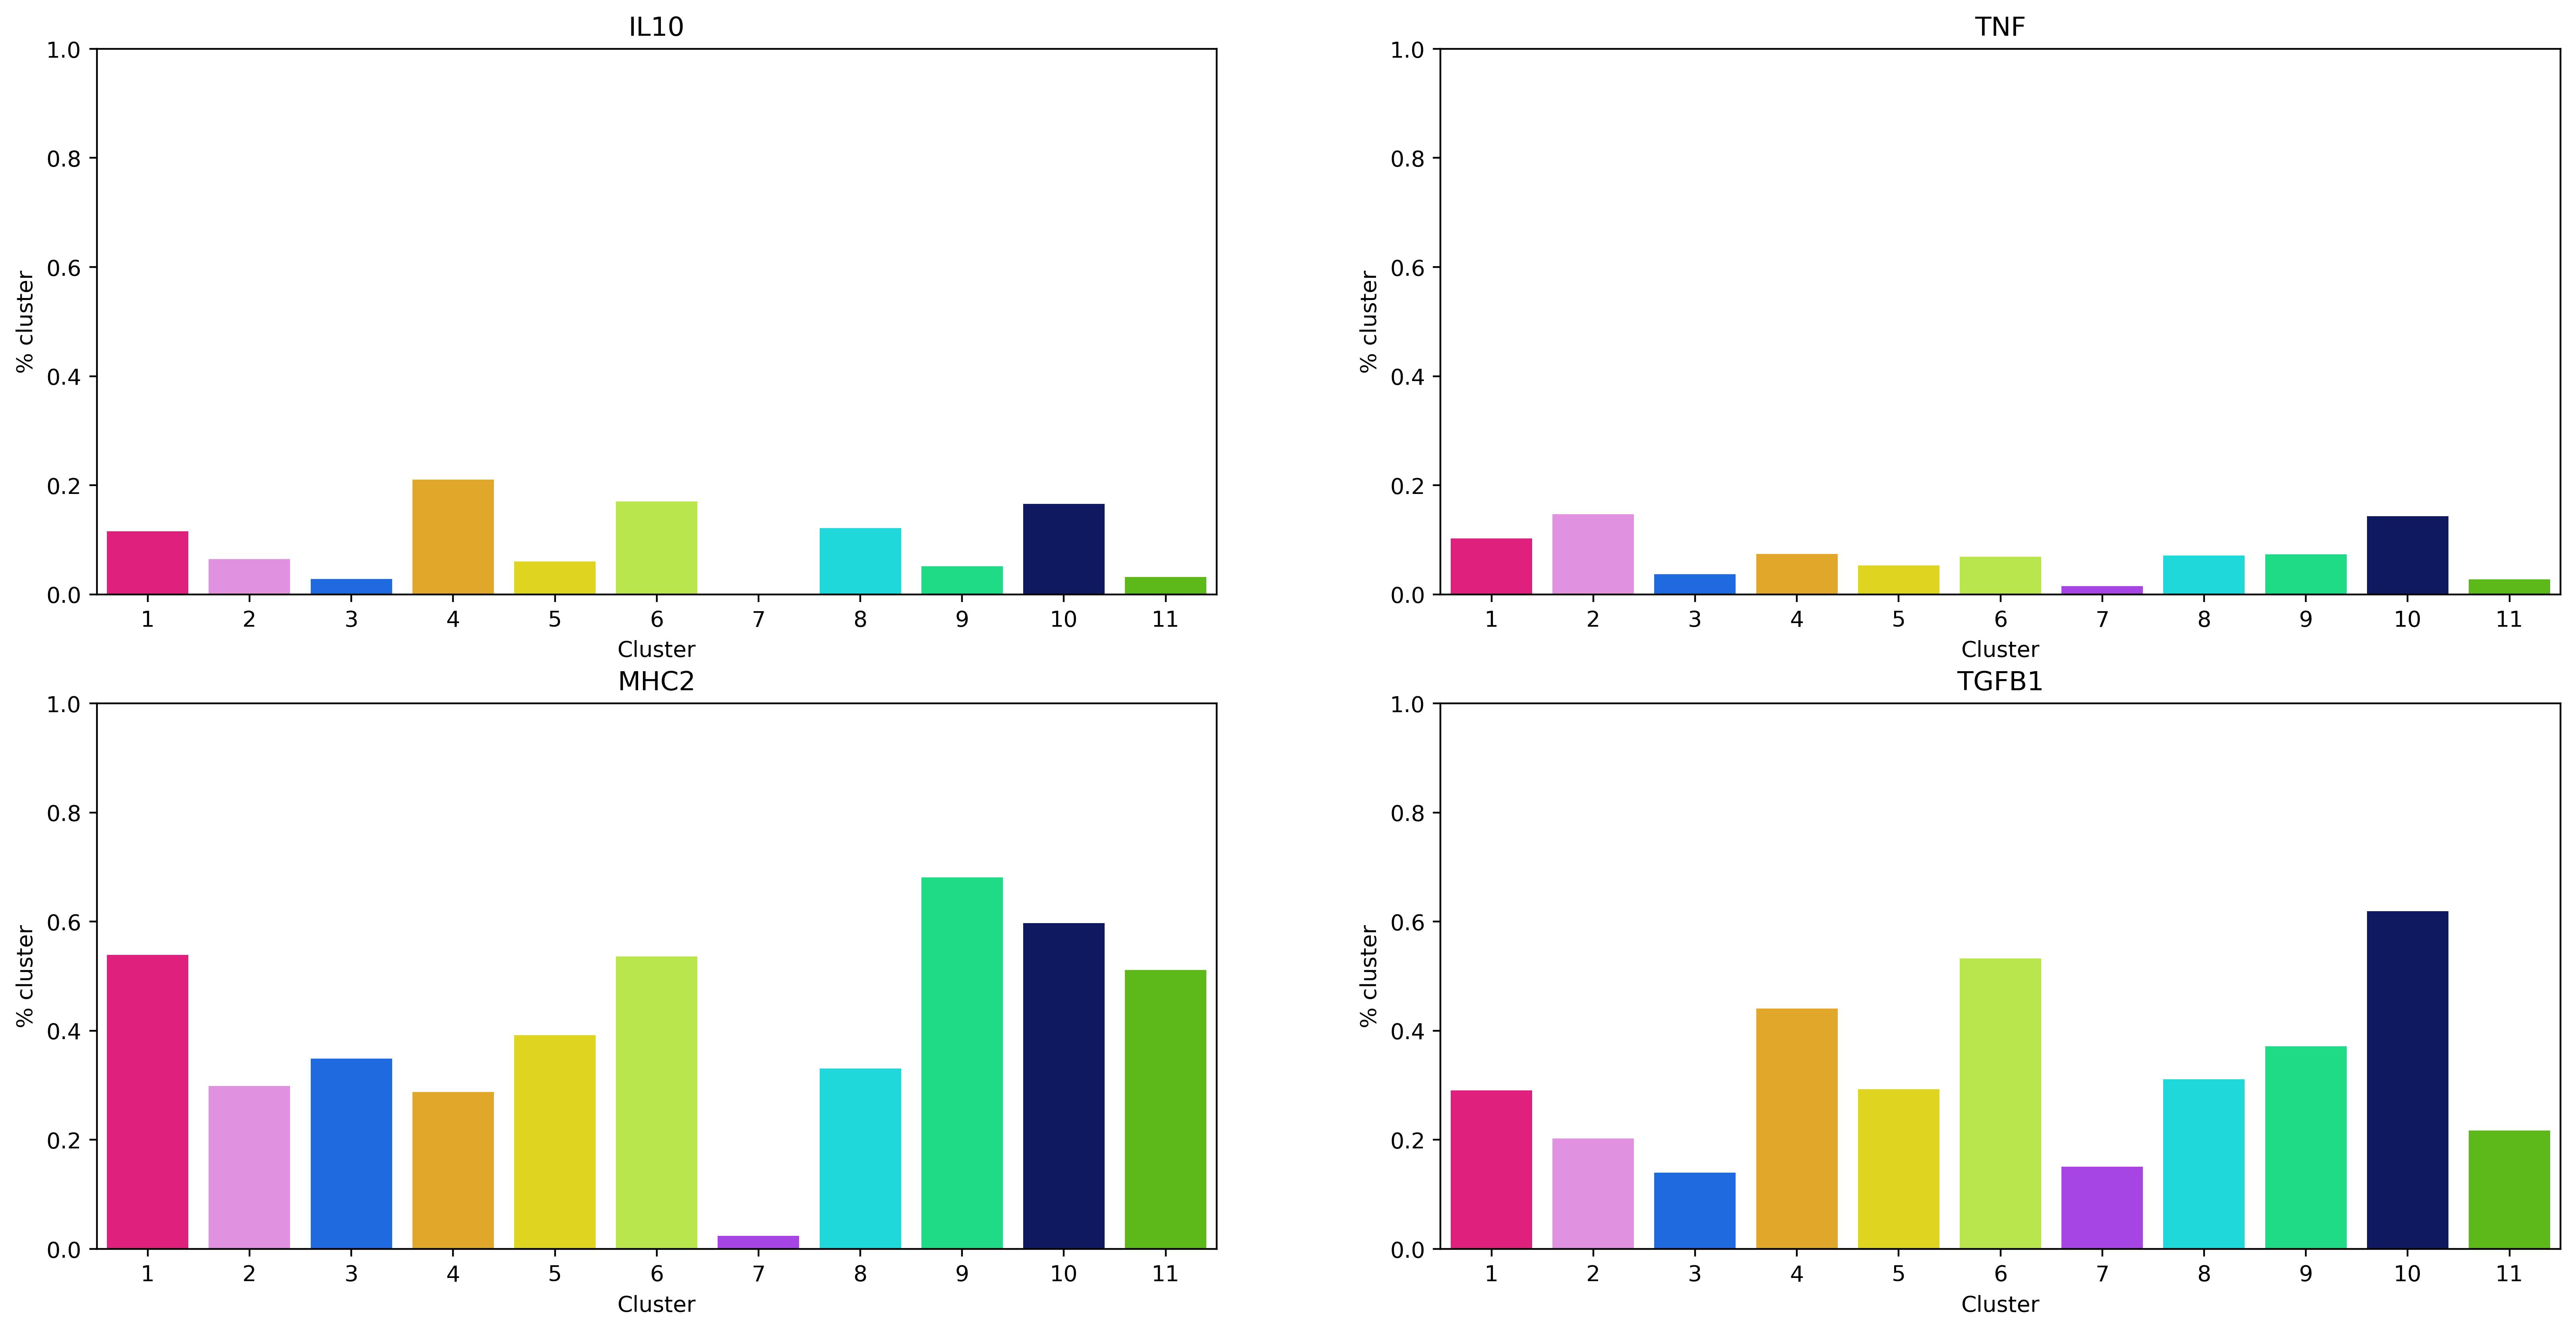

In [124]:
df#.pivot_table(index=['Cluster'], columns='Gene')

Cluster Group   Gene  % cluster
0       1    M2   IL10   0.115802
0       1    M2  TGFB1   0.290470
0       1    M1    TNF   0.102292
0       1    M1   MHC2   0.538888
0       2    M2   IL10   0.064539
0       2    M2  TGFB1   0.202637
0       2    M1    TNF   0.147120
0       2    M1   MHC2   0.298297
0       3    M2   IL10   0.028195
0       3    M2  TGFB1   0.139724
0       3    M1    TNF   0.036967
0       3    M1   MHC2   0.348708
0       4    M2   IL10   0.210264
0       4    M2  TGFB1   0.440747
0       4    M1    TNF   0.074028
0       4    M1   MHC2   0.287355
0       5    M2   IL10   0.060459
0       5    M2  TGFB1   0.292578
0       5    M1    TNF   0.052901
0       5    M1   MHC2   0.391861
0       6    M2   IL10   0.170370
0       6    M2  TGFB1   0.532346
0       6    M1    TNF   0.068642
0       6    M1   MHC2   0.536030
0       7    M2   IL10   0.000000
0       7    M2  TGFB1   0.150376
0       7    M1    TNF   0.015038
0       7    M1   MHC2   0.023713
0       8    M2   IL10   0.121407
0       8    M2  TGFB1   0.311192
0       8    M1    TNF   0.071449
0       8    M1   MHC2   0.330578
0       9    M2   IL10   0.051602
0       9    M2  TGFB1   0.371266
0       9    M1    TNF   0.073601
0       9    M1   MHC2   0.680796
0      10    M2   IL10   0.166001
0      10    M2  TGFB1   0.618939
0      10    M1    TNF   0.143183
0      10    M1   MHC2   0.597481
0      11    M2   IL10   0.031524
0      11    M2  TGFB1   0.217163
0      11    M1    TNF   0.027437
0      11    M1   MHC2   0.511294

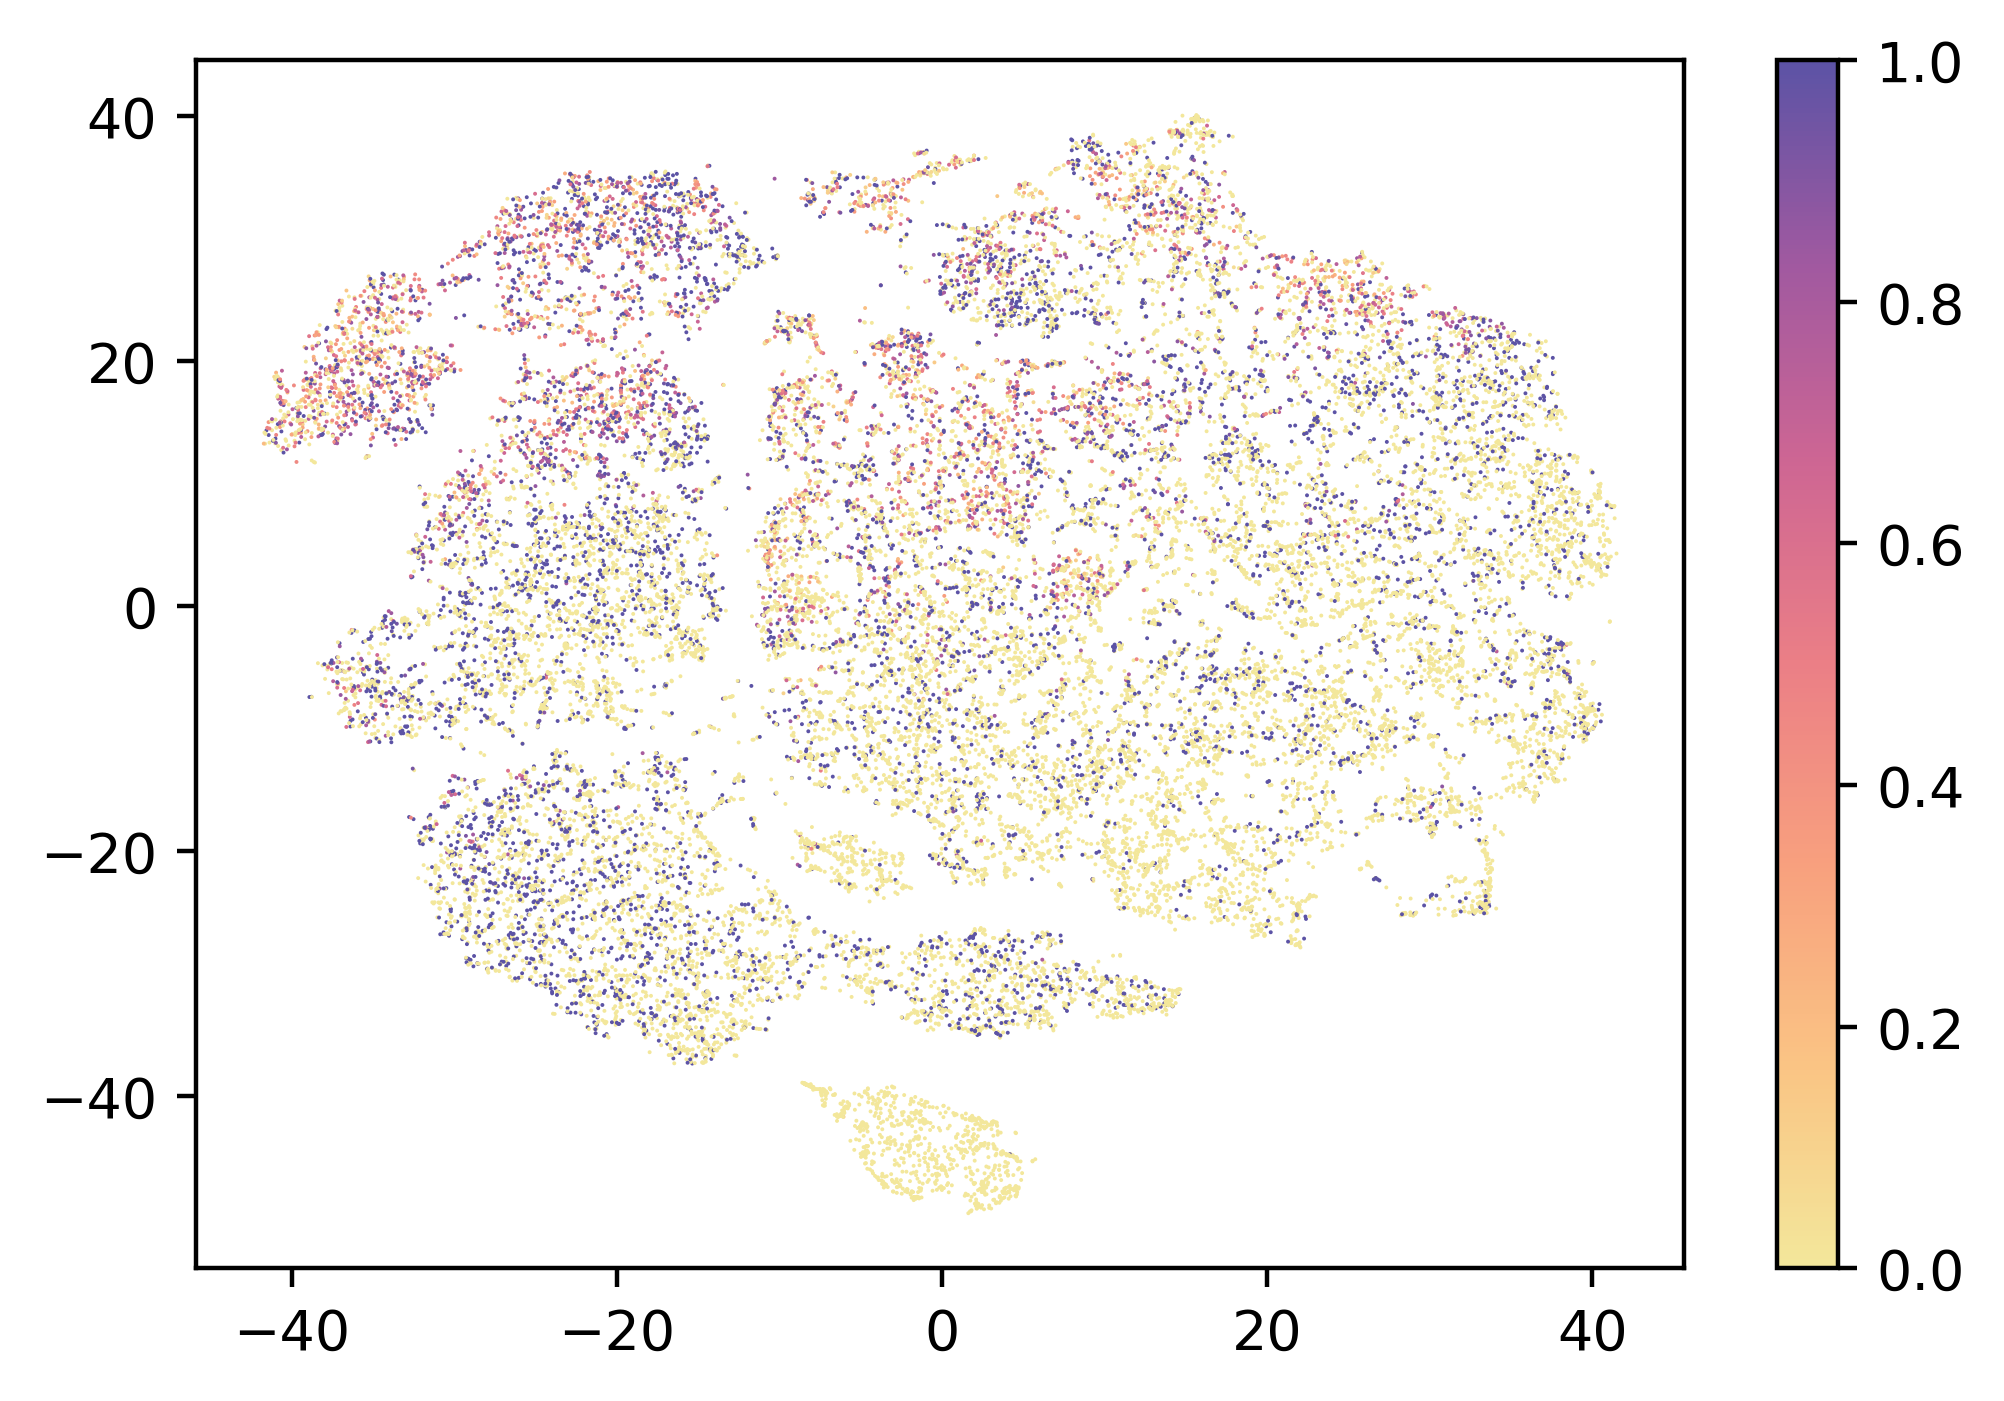

In [102]:
gene_name = 'TGFB1'
cmap = pickle.load(open(r'/storage/md_keren/shitay/garbage/cmap.pkl', 'rb'))
gene_idx =myeloid_cohort.gene_names.index(gene_name)
sc = plt.scatter(myeloid_cohort.tsne_X, myeloid_cohort.tsne_Y, cmap=cmap,
                 c=myeloid_cohort.zscore_nor_gene_exp[:, gene_idx], vmin=0, vmax=1., s=0.5, edgecolor='none');
plt.colorbar(sc);

In [8]:
o = 2729.82 + 410.19
b = 240 + 85 + 170 + 300
o-b

2345.01